# Player Similarity Scores on Many Players

Moving up, we're scaling the process described by **Player Similarity Scores**.
This abstracts many processes, so it's best to read this after the aforementioned paper!

## Abstractions

Some functions are moved to another file.
More importantly, the method of loading the scores are heavily abstracted with `PreprocessingDynamic` and `Dataset`, which are custom classes simplifying the loading process.

It implements filters:
- `unpopular_maps_thres`: Removes maps that aren't played by at least n% of the players
- `unpopular_players_thres`: Removes players that haven't played by at least n% of the maps
- `sr_min_thres`: Removes maps below this SR
- `acc_filter`: Removes scores outside this range

The result of the preprocessing is a better formatted `pd.DataFrame`

In [145]:
import warnings
from pathlib import Path

from sklearn.preprocessing import QuantileTransformer

from opal.score.dataset import Dataset
from opal.score.preprocessing_dynamic import PreprocessingDynamic
from opal.score.similarity.similarity import similarity_pair

warnings.filterwarnings('ignore')

data_path = Path("../../data/osu/scores/")

df = PreprocessingDynamic(
    Dataset(data_path, "top1k").joined_filtered_df,
    unpopular_maps_thres=0.2,
    unpopular_plays_thres=0.2,
    sr_min_thres=2.5,
    acc_filter=(0.85, 1),
    score_filter=None
).filter(calc_acc=True)
df = df[['map_id', 'user_id', 'accuracy', 'year']]
df = df.groupby(['user_id', 'year', 'map_id']).agg('mean').reset_index()
qt = QuantileTransformer()
# We fit_transform with numpy so we don't force QT to only work with a
# specific column name
df['accuracy_qt'] = qt.fit_transform(df[['accuracy']].to_numpy())
df_sim = similarity_pair(df, min_pair_plays=40)
df = df.set_index(['user_id', 'year'])

by_score_year 887452 -> 541019
by_sr 541019 -> 481548
by_unpopular_maps 481548 -> 279765
by_unpopular_plays 279765 -> 75055
by_acc_filter 75055 -> 74961
by_remove_mod 74961 -> 71327
Users Left: 291 | Beatmaps Left: 718


 71%|███████   | 46693/65703 [01:34<00:43, 435.75it/s]D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 71%|███████▏  | 46823/65703 [01:34<00:48, 392.56it/s]D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 71%|███████▏  | 46883/65703 [01:35<00:42, 445.79it/s]D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
D:\Repositories\PycharmProjects\opal\venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the par

We removed quite a few scores that didn't match our filters, but that's fine, we're working with better data!

We also generated the similarity matrix after some time, let's take a gander at it

<AxesSubplot:xlabel='user_id-year', ylabel='user_id-year'>

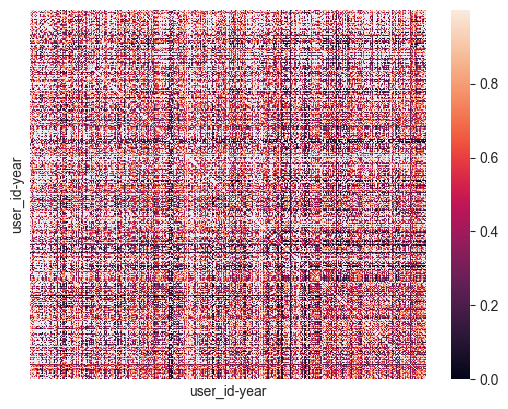

In [146]:
import seaborn as sns

sns.heatmap(df_sim, yticklabels=False, xticklabels=False)

Looks brilliant!

## Evaluation

Now, we need to evaluate how well this performs.

TL;DR: we find the prediction by taking the weighted average of scores per map that each user has played.

In order to do so:
- For each player (that exists in the similarity matrix), we:
    - Index the df with only their scores
    - Copy and create a df with their similarities of other players
    - Group by `map_id`:
        - Take the weighted average (weighted on similarity)
        - Get the support
    - Inverse Transform the `predict_qt`

In [229]:
from tqdm import tqdm
import pandas as pd
import numpy as np

df_users = []

for ix, sim in tqdm(df_sim.iterrows(), total=len(df_sim)):
    df_user = df.loc[ix].set_index('map_id')
    # Adds similarity as a column to the df
    #                        vvvv
    # +--------+--------+------------+
    # | map_id | acc_qt | similarity |
    # +--------+--------+------------+
    df_sim_user = pd.merge(
        df,
        sim.dropna().rename('similarity'),
        left_index=True, right_index=True
    )

    # Within each map, we find the weighted average (weighted by similarity)
    # +--------+--------+------------+
    # | map_id | acc_qt | similarity |
    # +--------+---^----+------^-----+
    #     (target) |           | (weights)
    #              +-----------+
    df_sim_gped = df_sim_user.groupby('map_id').apply(
        lambda g: np.average(g['accuracy_qt'], weights=g['similarity'])
    )
    # This will yield us a SINGLE prediction per map_id

    # We also COUNT the number of supports
    df_sim_supp = df_sim_user.groupby('map_id').agg('count').iloc[:, 0]

    # Join the prediction & support to the user df
    df_user = df_user.merge(df_sim_gped.rename('predict_qt'),
                            left_index=True, right_index=True)
    df_user = df_user.merge(df_sim_supp.rename('support'),
                            left_index=True, right_index=True)

    # Inverse transform the prediction_qt
    df_user['predict'] = qt.inverse_transform(df_user[['predict_qt']].to_numpy())

    df_users.append(df_user)

df_users = pd.concat(df_users)

100%|██████████| 363/363 [00:27<00:00, 13.10it/s]


### Evaluation Metrics

Let's evaluate the RMSE & R^2

In [231]:
from sklearn.metrics import r2_score, mean_squared_error

df_users['predict_a'] = df_users['predict'] ** 1.23
pred = df_users['predict_a']
actual = df_users['accuracy']
print(f"Accuracy MSE: {mean_squared_error(actual, pred, squared=False):.2%}")
print(f"R^2: {r2_score(actual, pred):.2%}")

Accuracy MSE: 1.77%
R^2: 52.12%


Also, let's plot the error!

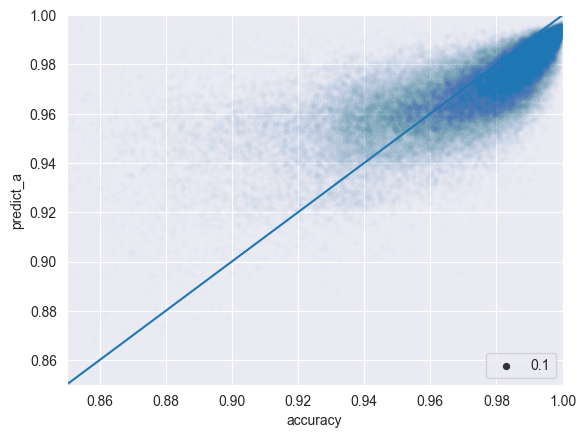

In [232]:
from matplotlib import pyplot as plt

sns.scatterplot(
    x='accuracy',
    y='predict_a',
    alpha=0.01,
    size=0.1,
    data=df_users
)
_ = plt.plot([0, 1], [0, 1])
_ = plt.xlim(0.85, 1)
_ = plt.ylim(0.85, 1)

## Correcting the Prediction

Oddly enough, the prediction is... curved?
Luckily, it seems to be consistent, so we can do a `curve_fit` and inverse it!

Here, we want to anchor the curve at (1, 1) as it seems to be the case here.

A function that seems to be similar is e^x, however it needs some tweaking.

- e^x is anchoring on (0, 1), so let's shift x
- e^(xa) will cause `a` to be limited to (0, inf) as `a<0` causes an incorrect trajectory.

Thus, we arrive at: `e^[(x-1)*e^a)]`. Seems complicated, the justifications are listed above.

Let's also plot how the function varies with `a`.

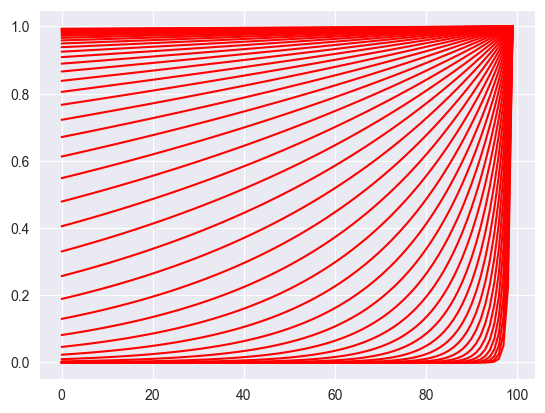

In [242]:
from scipy.optimize import curve_fit


def correction_fn(x, a):
    return np.exp((x - 1) * np.exp(a))


def inv_correction_fn(x, a):
    return np.exp(-a) * (np.exp(a) + np.log(x))


x = np.linspace(0, 1, 100)
for a in np.linspace(-5, 5, 50):
    plt.plot(correction_fn(x, a), color='red')

Looks great! We should be able to fit it well, and then inverse it.

Let's estimate `a`

In [244]:
curve_fit(correction_fn, df_users['accuracy'], df_users['predict'])[0]

array([-0.41151293])